# How to Develop an Information Maximizing GAN (InfoGAN) in Keras

The Generative Adversarial Network, or GAN, is an architecture for training deep convolutional models for generating synthetic images.

Although remarkably effective, the default GAN provides no control over the types of images that are generated. The Information Maximizing GAN, or InfoGAN for short, is an extension to the GAN architecture that introduces control variables that are automatically learned by the architecture and allow control over the generated image, such as style, thickness, and type in the case of generating images of handwritten digits.

In this tutorial, you will discover how to implement an Information Maximizing Generative Adversarial Network model from scratch.

After completing this tutorial, you will know:

- The InfoGAN is motivated by the desire to disentangle and control the properties in generated images.
- The InfoGAN involves the addition of control variables to generate an auxiliary model that predicts the control variables, trained via mutual information loss function.
- How to develop and train an InfoGAN model from scratch and use the control variables to control which digit is generated by the model.

# Tutorial Overview
This tutorial is divided into four parts; they are:

- What Is the Information Maximizing GAN
- How to Implement the InfoGAN Loss Function
- How to Develop an InfoGAN for MNIST
- How to Use Control Codes With a Trained InfoGAN Model
- What Is the Information Maximizing GAN

The Generative Adversarial Network, or GAN for short, is an architecture for training a generative model, such as a model for generating synthetic images.

It involves the simultaneous training of the generator model for generating images with a discriminator model that learns to classify images as either real (from the training dataset) or fake (generated). The two models compete in a zero-sum game such that convergence of the training process involves finding a balance between the generator’s skill in generating convincing images and the discriminator’s in being able to detect them.

The generator model takes as input a random point from a latent space, typically 50 to 100 random Gaussian variables. The generator applies a unique meaning to the points in the latent space via training and maps points to specific output synthetic images. This means that although the latent space is structured by the generator model, there is no control over the generated image.




_The GAN formulation uses a simple factored continuous input noise vector z, while imposing no restrictions on the manner in which the generator may use this noise. As a result, it is possible that the noise will be used by the generator in a highly entangled way, causing the individual dimensions of z to not correspond to __semantic features__ of the data._

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.



The latent space can be explored and generated images compared in an attempt to understand the mapping that the generator model has learned. Alternatively, the generation process can be conditioned, such as via a class label, so that images of a specific type can be created on demand. This is the basis for the __Conditional Generative Adversarial Network, CGAN or cGAN for short__.

Another approach is to provide control variables as input to the generator, along with the point in latent space (noise). The generator can be trained to use the control variables to influence specific properties of the generated images. This is the approach taken with the Information Maximizing Generative Adversarial Network, or InfoGAN for short.

_"__InfoGAN__, an information-theoretic extension to the Generative Adversarial Network that is able to __learn disentangled representations__ in a __completely unsupervised manner__"_

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

The structured mapping learned by the generator during the training process is somewhat random. Although the generator model learns to spatially separate properties of generated images in the latent space, there is no control. The properties are entangled. The InfoGAN is motivated by the desire to disentangle the properties of generated images.

For example, in the case of faces, the properties of generating a face can be disentangled and controlled, such as the shape of the face, hair color, hairstyle, and so on.

_For example, for a dataset of faces, a useful disentangled representation may allocate a separate set of dimensions for each of the following attributes: facial expression, eye color, hairstyle, presence or absence of eyeglasses, and the identity of the corresponding person._

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

Control variables are provided along with the noise as input to the generator and the model is trained via a mutual information loss function.

_… we present a simple modification to the generative adversarial network objective that encourages it to learn interpretable and meaningful representations. __We do so by maximizing the mutual information between a fixed small subset of the GAN’s noise variables and the observations, which turns out to be relatively straightforward.___

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

Mutual information refers to the amount of information learned about one variable given another variable. In this case, we are interested in the information about the control variables given the image generated using noise and the control variables.

In information theory, mutual information between $X$ and $Y$ , $I(X; Y )$, measures the “amount of information” learned from knowledge of random variable $Y$ about the other random variable $X$.

The Mutual Information (MI) is calculated as the conditional entropy of the image (created by the generator (G) from the noise (z) and the control variable (c)) given the control variables (c) subtracted from the marginal entropy of the control variables (c); for example:

$$ MI = Entropy(c) – Entropy(c | G(z,c))$$

Calculating the true mutual information, in practice, is often intractable, although simplifications are adopted in the paper, referred to as Variational Information Maximization, and the entropy for the control codes is kept constant.

Training the generator via mutual information is achieved through the use of a new model, referred to as $Q$ or the auxiliary model. The new model shares all of the same weights as the discriminator model for interpreting an input image, but unlike the discriminator model that predicts whether the image is real or fake, __the auxiliary model predicts the control codes that were used to generate the image.__

Both models are used to update the generator model, first to improve the likelihood of generating images that fool the discriminator model, and second to improve the mutual information between the control codes used to generate an image and the auxiliary model’s prediction of the control codes.

The result is that the generator model is regularized via mutual information loss such that the control codes capture salient properties of the generated images and, in turn, can be used to control the image generation process.

_… mutual information can be utilized whenever we are interested in learning a parametrized mapping from a given input X to a higher level representation Y which preserves information about the original input. […] show that the task of maximizing mutual information is essentially equivalent to training an autoencoder to minimize reconstruction error._

— Understanding Mutual Information and its use in InfoGAN, 2016.

# How to Implement the InfoGAN Loss Function
The InfoGAN is reasonably straightforward to implement once you are familiar with the inputs and outputs of the model.

The only stumbling block might be the mutual information loss function, especially if you don’t have a strong math background, like most developers.

There are __two main types__ of ___control variables___ used with the InfoGan: __categorical__ and __continuous__, and _continuous variables may have different data distributions_, which impact how the mutual loss is calculated. 

The mutual loss can be calculated and summed across all control variables based on the variable type, and this is the approach used in the official InfoGAN implementation released by OpenAI for TensorFlow.

In Keras, it might be easier to simplify the control variables to __categorical__ and either __Gaussian__ or __Uniform__ continuous variables and have separate outputs on the auxiliary model for each control variable type. This is so that a different loss function can be used, greatly simplifying the implementation.

See the papers and posts in the further reading section for more background on the recommendations in this section.

__Categorical Control Variables__

The categorical variable may be used to control the type or class of the generated image.

This is implemented as a one hot encoded vector. That is, if the class has 10 values, then the control code would be one class, e.g. 6, and the categorical control vector input to the generator model would be a 10 element vector of all zero values with a one value for class 6, for example, [0, 0, 0, 0, 0, 0, 1, 0, 0].

___We do not need to choose the categorical control variables when training the model; instead, they are generated randomly, e.g. each selected with a uniform probability for each sample.___

_… a uniform categorical distribution on latent codes c ∼ Cat(K = 10, p = 0.1)_

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

In the auxiliary model, the output layer for the categorical variable would also be a one hot encoded vector to match the input control code, and the softmax activation function is used.

_For categorical latent code $ci$ , we use the natural choice of __softmax__ nonlinearity to represent $Q(ci |x)$.

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

Recall that the mutual information is calculated as the conditional entropy from the control variable and the output of the auxiliary model subtracted from the entropy of the control variable provided to the input variable. We can implement this directly, but it’s not necessary.

The __entropy of the control variable__ is a __constant__ and comes out to be a __very small number close to zero__; as such, __we can remove it from our calculation__. The conditional entropy can be calculated directly as the cross-entropy between the control variable input and the output from the auxiliary model. Therefore, the categorical cross-entropy loss function can be used, as we would on any multi-class classification problem.

$$ MI = Entropy(c) – Entropy(c | G(z,c)) = $$
$$ Entropy(c) = 0$$
If c is categorical
$$ MI = – Entropy(c | G(z,c)) = cross_entropy(Q(G(z,c)))$$

A hyperparameter, lambda $\lambda$, is used to scale the mutual information loss function and is set to 1, and therefore can be ignored.

_Even though InfoGAN introduces an extra hyperparameter $\lambda$, it’s easy to tune and simply setting to 1 is sufficient for discrete latent codes._

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

__Continuous Control Variables__

The continuous control variables may be used to control the style of the image.

The continuous variables are sampled from a uniform distribution, such as between -1 and 1, and provided as input to the generator model.

_… continuous codes that can capture variations that are continuous in nature: c2, c3 ∼ Unif(−1, 1)_

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

The auxiliary model can implement the prediction of continuous control variables with a Gaussian distribution, where the output layer is configured to have one node, the mean, and one node for the standard deviation of the Gaussian, e.g. two outputs are required for each continuous control variable.

_For continuous latent code $cj$ , there are more options depending on what is the true posterior $P(cj |x)$. In our experiments, we have found that simply treating Q(cj |x) as a factored Gaussian is sufficient._

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

Nodes that output the __mean__ can use a __linear activation__ function, whereas nodes that output the __standard deviation__ must produce a _positive value_, therefore an activation function such as the __sigmoid__ can be used to _create a value between 0 and 1_.

_For continuous latent codes, we parameterize the approximate posterior through a diagonal Gaussian distribution, and the recognition network outputs its mean and standard deviation, where the standard deviation is parameterized through an exponential transformation of the network output to ensure positivity._

— InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets, 2016.

The loss function must be calculated as the mutual information on the Gaussian control codes, meaning they must be reconstructed from the mean and standard deviation prior to calculating the loss. Calculating the entropy and conditional entropy for Gaussian distributed variables can be implemented directly, although is not necessary. Instead, the __mean squared error__ loss can be used.

Alternately, the output distribution can be simplified to a __uniform distribution__ for each control variable, a __single output node for each variable__ in the auxiliary model $Q$ with __linear activation__ can be used, and the model can use the __mean squared error loss__ function.

__But how to decide on the number, type and parameters of control vars?__

How to know how many categorical c's to include in the model?

What are the cardinality (K=10) of the vars?

How many continous vars?

All the above questions are open, and can only be subject to experimentation.


# How to Develop an InfoGAN for MNIST
In this section, we will take a closer look at the generator (g), discriminator (d), and auxiliary models (q) and how to implement them in Keras.

We will develop an InfoGAN implementation for the MNIST dataset, as was done in the InfoGAN paper.

The paper explores two versions; 

- the first uses just categorical control codes and allows the model to map one categorical variable to approximately one digit __(although there is no ordering of the digits by categorical variables).__

- The paper also explores a version of the InfoGAN architecture with the one hot encoded categorical variable (c1) and two continuous control variables (c2 and c3).

The first continuous variable is discovered to control the _rotation_ of the digits and the second controls the _thickness_ of the digits.

_We will focus on the simpler case of using a categorical control variable with 10 values and encourage the model to learn to let this variable control the generated digit._ 

You may want to extend this example by either changing the cardinality of the categorical control variable or adding continuous control variables.

The configuration of the GAN model used for training on the MNIST dataset was provided as an appendix to the paper, reproduced below. We will use the listed configuration as a starting point in developing our own generator (g),  discriminator (d), and auxiliary (q) models.

# G

Let’s start off by developing the generator model as a deep convolutional neural network (e.g. a DCGAN).

The model could take the noise vector (z) and control vector (c) as separate inputs and concatenate them before using them as the basis for generating the image. Alternately, the vectors can be concatenated beforehand and provided to a single input layer in the model. The approaches are equivalent and we will use the latter in this case to keep the model simple.

The `define_generator()` function below defines the generator model and takes the size of the input vector as an argument.

A fully connected layer takes the input vector and produces a sufficient number of activations to create 512 7×7 feature maps from which the activations are reshaped. These then pass through a normal convolutional layer with 1×1 stride, then two subsequent upsamplings transpose convolutional layers with a 2×2 stride first to 14×14 feature maps then to the desired 1 channel 28×28 feature map output with pixel values in the range [-1,-1] via a tanh activation function.

Good generator configuration heuristics are as follows, including a random Gaussian weight initialization, ReLU activations in the hidden layers, and use of batch normalization.

In [0]:
# define the standalone generator model
def define_generator(gen_input_size):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image generator input
	in_lat = Input(shape=(gen_input_size,))
	# foundation for 7x7 image
	n_nodes = 512 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Reshape((7, 7, 512))(gen)
	# normal
	gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	# tanh output
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

Next, we can define the discriminator and auxiliary models.

# D and Q
The discriminator model is trained in a standalone manner on real and fake images, as per a normal GAN. 

___Neither the generator nor the auxiliary models are fit directly; instead, they are fit as part of a composite model.___


Both the discriminator and auxiliary models share the same input and feature extraction layers but differ in their output layers. Therefore, it makes sense to define them both at the same time.

Again, there are many ways that this architecture could be implemented, but defining the discriminator and auxiliary models as separate models first allows us later to combine them into a larger GAN model directly via the functional API.

The `define_discriminator()` function below defines the __discriminator__ and __auxiliary__ models and takes the __cardinality of the categorical variable__ (e.g.number of values, such as 10) as an __input__. The shape of the input image is also parameterized as a function argument and set to the default value of the size of the MNIST images.

The feature extraction layers involve two downsampling layers, used instead of pooling layers as a best practice. Also following best practice for DCGAN models, we use the LeakyReLU activation and batch normalization.


# D
The discriminator model (d) has a single __output__ node and predicts the probability of an input image being __real__ via the __sigmoid__ activation function. __The model is compiled as it will be used in a standalone way__, optimizing the __binary cross entropy function__ via the Adam version of stochastic gradient descent with best practice learning rate and momentum.

# Q
The auxiliary model (q) has __one node output for each value in the categorical variable__ and uses a __softmax__ activation function. A fully connected layer is added between the feature extraction layers and the output layer, as was used in the InfoGAN paper. __The model is not compiled as it is not for or used in a standalone manner.__

In [0]:
# define the standalone discriminator model
def define_discriminator(n_cat, in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.1)(d)
	# downsample to 7x7
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	# normal
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	# flatten feature maps
	d = Flatten()(d)
	# real/fake output
	out_classifier = Dense(1, activation='sigmoid')(d)
	# define d model
	d_model = Model(in_image, out_classifier)
	# compile d model
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	# create q model layers
	q = Dense(128)(d)
	q = BatchNormalization()(q)
	q = LeakyReLU(alpha=0.1)(q)
	# q model output
	out_codes = Dense(n_cat, activation='softmax')(q)
	# define q model
	q_model = Model(in_image, out_codes)
	return d_model, q_model

# GAN
Next, we can define the composite GAN model.

This model uses all submodels and is the basis for training the weights of the generator model.

The `define_gan()` function below implements this and defines and returns the model, taking the three submodels as input.


The _discriminator is trained in a standalone manner as mentioned_, therefore all ___weights of the discriminator are set as not trainable (in this context only)___. 


__The output of the generator model is connected to the input of the discriminator model, and to the input of the auxiliary model.__

This creates a new composite model that takes a [noise + control] vector as input, that then passes through the generator to produce an image. 

The image then passes through the discriminator model to produce a classification and through the auxiliary model to produce a prediction of the control variables.

The model has two output layers that need to be trained with different loss functions. 

- Binary cross entropy loss is used for the discriminator output, as we did when compiling the discriminator for standalone use, and 

- mutual information loss is used for the auxiliary model, which, in this case, can be implemented directly as ___categorical cross-entropy___ and achieve the desired result.

In [0]:
# define the combined discriminator, generator and q network model
def define_gan(g_model, d_model, q_model):
	# make weights in the discriminator (some shared with the q model) as not trainable
	d_model.trainable = False
	# connect g outputs to d inputs
	d_output = d_model(g_model.output)
	# connect g outputs to q inputs
	q_output = q_model(g_model.output)
	# define composite model
	model = Model(g_model.input, [d_output, q_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

Putting all together

In [0]:
# create and plot the infogan model for mnist
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 62
# create the discriminator
d_model, q_model = define_discriminator(n_cat)
# create the generator
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
# plot the model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
gan_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 25088)        1831424     input_6[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 25088)        0           dense_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 25088)        100352      activation_9[0][0]               
__________________________________________________________________________________________________
reshape_3 

Next, we will develop inputs for the generator.

Each input will be a vector comprised of _noise and the control codes_. 

Specifically, a vector of Gaussian random numbers and a one hot encoded randomly selected categorical value.


The `generate_latent_points()` function below implements this, taking as input the size of the latent space, the number of categorical values, and the number of samples to generate as arguments. 

The function returns the input _concatenated vectors_ as input for the generator model, as well as the _standalone control codes_. 

The standalone control codes will be required when updating the generator and auxiliary models via the composite GAN model, specifically for calculating the __mutual information loss for the auxiliary model.__

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate categorical codes
	cat_codes = randint(0, n_cat, n_samples)
	# one hot encode
	cat_codes = to_categorical(cat_codes, num_classes=n_cat)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, cat_codes))
	return [z_input, cat_codes]

# Data preparation
Next, we can generate real and fake examples.

The MNIST dataset can be loaded, transformed into 3D input by adding an additional dimension for the grayscale images, and scaling all pixel values to the range [-1,1] to match the output from the generator model. This is implemented in the `load_real_samples()` function below.

We can retrieve batches of real samples required when training the discriminator by choosing a random subset of the dataset. This is implemented in the `generate_real_samples()` function below that returns the images and the class label of 1, to indicate to the discriminator that they are real images.

The discriminator also requires batches of _fake samples_ generated via the generator, using the vectors from generate_latent_points() function as input. The `generate_fake_samples()` function below implements this, returning the generated images along with the class label of 0, to indicate to the discriminator that they are fake images.

In [0]:
# load images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape)
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images and labels
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
	# generate points in latent space and control codes
	z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

Next, we need to keep track of the quality of the generated images.

We will periodically use the generator to generate a sample of images and save the generator and composite models to file. We can then review the generated images at the end of training in order to choose a final generator model and load the model to start using it to generate images.

The `summarize_performance()` function below implements this, first generating 100 images, scaling their pixel values back to the range [0,1], and saving them as a plot of images in a 10×10 square.

The generator and composite GAN models are also saved to file, with a unique filename based on the training iteration number.

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, gan_model, latent_dim, n_cat, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_cat, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the gan model
	filename3 = 'gan_model_%04d.h5' % (step+1)
	gan_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

# Train InfoGAN
Finally, we can train the InfoGAN.

This is implemented in the `train()` function below that takes the defined models and configuration as arguments and runs the training process.

The models are trained for 100 epochs and 64 samples are used in each batch. There are 60,000 images in the MNIST training dataset, therefore one epoch involves 60,000/64, or 937 batches or training iterations. Multiplying this by the number of epochs, or 100, means that there will be a total of 93,700 total training iterations.

Each training iteration involves:

- first updating the discriminator with half a batch of real samples and half a batch of fake samples to form one batch worth of weight updates, or 64, each iteration. 

- Next, the composite GAN model is updated based on a batch worth of noise and control code inputs. 

The loss of the discriminator on real and fake images and the loss of the generator and auxiliary model is reported each training iteration.

__Generated samples are marked 'real' when the composite model is trained__

```
# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the g via the d and q error
		_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
```

This is to fulfill the min_max objective, where we want to fool _D_ so we give it G(z,c) samples as real '=1'


In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=10, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator and q model weights
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
		# update discriminator model weights
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# prepare points in latent space as input for the generator
		z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the g via the d and q error
		_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
		# summarize loss on this batch
		print('>%d, d[%.3f,%.3f], g[%.3f] q[%.3f]' % (i+1, d_loss1, d_loss2, g_1, g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, gan_model, latent_dim, n_cat)

We can then configure and create the models, then run the training process.

We will use 10 values for the single categorical variable to match the 10 known classes in the MNIST dataset. 

We will use a latent space with 64 dimensions to match the InfoGAN paper, meaning, in this case, each input vector to the generator model will be 64 (random Gaussian variables) + 10 (one hot encoded control variable) or 72 elements in length.

In [23]:
# example of training an infogan on mnist
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Activation
from matplotlib import pyplot


# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 62
# create the discriminator
d_model, q_model = define_discriminator(n_cat)
# create the generator
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
# create the gan
gan_model = define_gan(g_model, d_model, q_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat)

(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d[0.683,0.717], g[0.294] q[2.809]
>2, d[0.000,2.591], g[0.545] q[2.777]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>3, d[0.000,1.774], g[1.266] q[2.649]
>4, d[0.000,0.995], g[1.869] q[2.562]
>5, d[0.000,0.889], g[2.002] q[2.525]
>6, d[0.000,0.912], g[1.953] q[2.395]
>7, d[0.000,1.022], g[2.074] q[2.259]
>8, d[0.000,0.819], g[2.278] q[2.362]
>9, d[0.000,1.035], g[2.333] q[2.450]
>10, d[0.000,0.859], g[2.631] q[2.320]
>11, d[0.000,0.663], g[2.264] q[2.490]
>12, d[0.001,0.569], g[2.297] q[2.028]
>13, d[0.001,0.729], g[2.214] q[2.061]
>14, d[0.000,0.769], g[2.094] q[2.031]
>15, d[0.001,0.652], g[2.487] q[1.967]
>16, d[0.006,0.651], g[2.318] q[2.068]
>17, d[0.001,0.546], g[2.412] q[1.918]
>18, d[0.004,0.828], g[2.528] q[1.910]
>19, d[0.006,0.600], g[2.661] q[1.859]
>20, d[0.003,0.425], g[2.425] q[1.713]
>21, d[0.002,0.857], g[2.488] q[1.699]
>22, d[0.003,0.550], g[2.524] q[1.845]
>23, d[0.005,0.642], g[2.762] q[1.732]
>24, d[0.007,0.775], g[2.892] q[1.857]
>25, d[0.003,0.448], g[2.977] q[1.575]
>26, d[0.004,0.745], g[2.907] q[1.421]
>27, d[0.007,0.548], g[2.816] q[1.493]
>28, d[0.022,0.764], g[3.158] q[

The loss across the models is reported each training iteration. If the loss for the discriminator remains at 0.0 or goes to 0.0 for an extended time, this may be a sign of a training failure and you may want to restart the training process. The discriminator loss may start at 0.0, but will likely rise, as it did in this specific case.

The loss for the auxiliary model will likely go to zero, as it perfectly predicts the categorical variable. Loss for the generator and discriminator models is likely to hover around 1.0 eventually, to demonstrate a stable training process or equilibrium between the training of the two models.

Plots and models are saved every epoch.

Reviewing the plots should show poor quality images in early epochs and improved and stable quality images in later epochs.

More epochs does not mean better quality, meaning that the best quality images may not be those from the final model saved at the end of training.

# How to Use Control Codes With a Trained InfoGAN Model
Now that we have trained the InfoGAN model, we can explore how to use it.

First, we can load the model and use it to generate random images, as we did during training.

The complete example is listed below.

Change the model filename to match the model filename that generated the best images during your training run.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


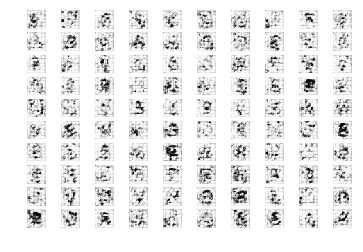

In [24]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from keras.utils import to_categorical
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# generate categorical codes
	cat_codes = randint(0, n_cat, n_samples)
	# one hot encode
	cat_codes = to_categorical(cat_codes, num_classes=n_cat)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, cat_codes))
	return [z_input, cat_codes]

# create a plot of generated images
def create_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_0937.h5')
# number of values for the categorical control code
n_cat = 10
# size of the latent space
latent_dim = 62
# number of examples to generate
n_samples = 100
# generate points in latent space and control codes
z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
# predict outputs
X = model.predict(z_input)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, n_samples)

Running the example will load the saved generator model and use it to generate 100 random images and plot the images on a 10×10 grid.



Next, we can update the example to test how much control our control variable gives us.

We can update the `generate_latent_points()` function to __take an argument of the value for the categorical value in [0,9]__, encode it, and use it as input along with noise vectors.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_cat, n_samples, digit):
	# generate points in the latent space
	z_latent = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_latent = z_latent.reshape(n_samples, latent_dim)
	# define categorical codes
	cat_codes = asarray([digit for _ in range(n_samples)])
	# one hot encode
	cat_codes = to_categorical(cat_codes, num_classes=n_cat)
	# concatenate latent points and control codes
	z_input = hstack((z_latent, cat_codes))
	return [z_input, cat_codes]

We can test this by generating a grid of 25 images with the categorical value 1.

The complete example is listed below.

Play with the variable `digit` to see the effect of the latent control var.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


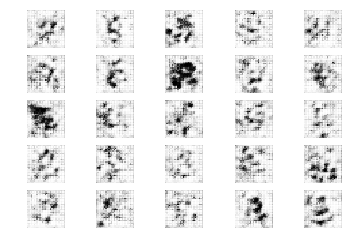

In [26]:
# example of testing different values of the categorical control variable
from math import sqrt
from numpy import asarray
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from keras.utils import to_categorical
from matplotlib import pyplot


# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_0937.h5')
# number of categorical control codes
n_cat = 10
# size of the latent space
latent_dim = 62
# number of examples to generate
n_samples = 25
# define digit
digit = 1
# generate points in latent space and control codes
z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples, digit)
# predict outputs
X = model.predict(z_input)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_samples)